#  <span style="font-family: Latin Modern Roman; font-size: 35px; font-weight: bold;"> Project 2. Recommender Systems </span>

## <span style="font-family: Latin Modern Roman; font-size: 25px;"> 1. Introduction </span>
<div style="text-align: justify;">

Recommender systems are capable of providing consumers with tailored suggestions, pointing them toward products they are likely to appreciate but would not have discovered on their own, by examining trends in their behavior, interests, and interactions. These systems are essential for raising engagement in the world of music streaming and discovery services such as Last.fm. In order to match listeners with music that suits their likes, the aim of this project is to construct a recommender system that combs through the enourmous database of songs, artists, and genres based on information of listener history.

The combination of listening counts, artist popularity, user-generated tags, and the rich set of artist attributes in this dataset provides a comprehensive foundation for creating a music recommender system. Such a system could leverage:

- **Collaborative filtering**: based on user listening patterns.

- **Content-based filtering**: based on artist attributes and tags.

</div>

---

## <span style="font-family: Latin Modern Roman; font-size: 25px;"> 2. Exploratory Data Analysis </span>

## <span style="font-family: Latin Modern Roman; font-size: 20px; font-style: italic;"> Variables </span>
<div style="text-align: justify;">

**Artists Data:**

This table contains information about music artists listened to and tagged by the users.

* `artistID`: unique identifier for each artist.

* `name`: name of the artist.

* `freq`: how often the artist appears in the dataset.

* `listeners`: number of users who have listened to the artist.

**Tags Data:**

This table contains the set of tags or genres available.

* `tagID`: unique identifier for each tag.

* `tagValue`: name of the tag, which can represent a genre, mood, era, or any other music-related attribute.

**User-Artist Data Data:**

This table captures which artists users have listened to, including a count of listening events.

* `userID`: unique identifier for each user.

* `artistID`: artist listened to by the user.

* `weight`: count of how many times the user has listened to the artist, indicative of the user's preference strength for that artist.

**User-Tagged Artists Data**

This table contains the tags that users have assigned to artists, along with timestamps indicating when the tagging occurred.

* `userID`, `artistID`, `tagID`: identifiers linking users, artists, and tags.

* `day`, `month`, `year`: date when the tag was assigned, providing temporal context.


In [2]:
import pandas as pd 

artists = pd.read_csv('./hetrec2011-lastfm-2k/artists-v2.dat', header=0, sep='\t')
user_tag_artist = pd.read_csv('./hetrec2011-lastfm-2k/user_taggedartists.dat', header=0, sep='\t')
tags = pd.read_csv('hetrec2011-lastfm-2k/tags.dat', header=0, sep='\t', encoding='latin-1')
users = pd.read_csv('hetrec2011-lastfm-2k/user_artists.dat',header=0, sep='\t')


In [3]:
print("Artists Data:")
print(artists.head())

Artists Data:
   artistID            name  freq  listeners
0        89       Lady Gaga   611    3798959
1       289  Britney Spears   522    3243214
2       288         Rihanna   484    4542147
3       227     The Beatles   480    3658694
4       300      Katy Perry   473    3721531


In [4]:
print("\nUser-Tagged Artists Data:")
print(user_tag_artist.head())


User-Tagged Artists Data:
   userID  artistID  tagID  day  month  year
0       2        52     13    1      4  2009
1       2        52     15    1      4  2009
2       2        52     18    1      4  2009
3       2        52     21    1      4  2009
4       2        52     41    1      4  2009


In [5]:
print("\nTags Data:")
print(tags.head())


Tags Data:
   tagID           tagValue
0      1              metal
1      2  alternative metal
2      3          goth rock
3      4        black metal
4      5        death metal


In [6]:
print("\nUsers Data:")
print(users.head())


Users Data:
   userID  artistID  weight
0       2        51   13883
1       2        52   11690
2       2        53   11351
3       2        54   10300
4       2        55    8983


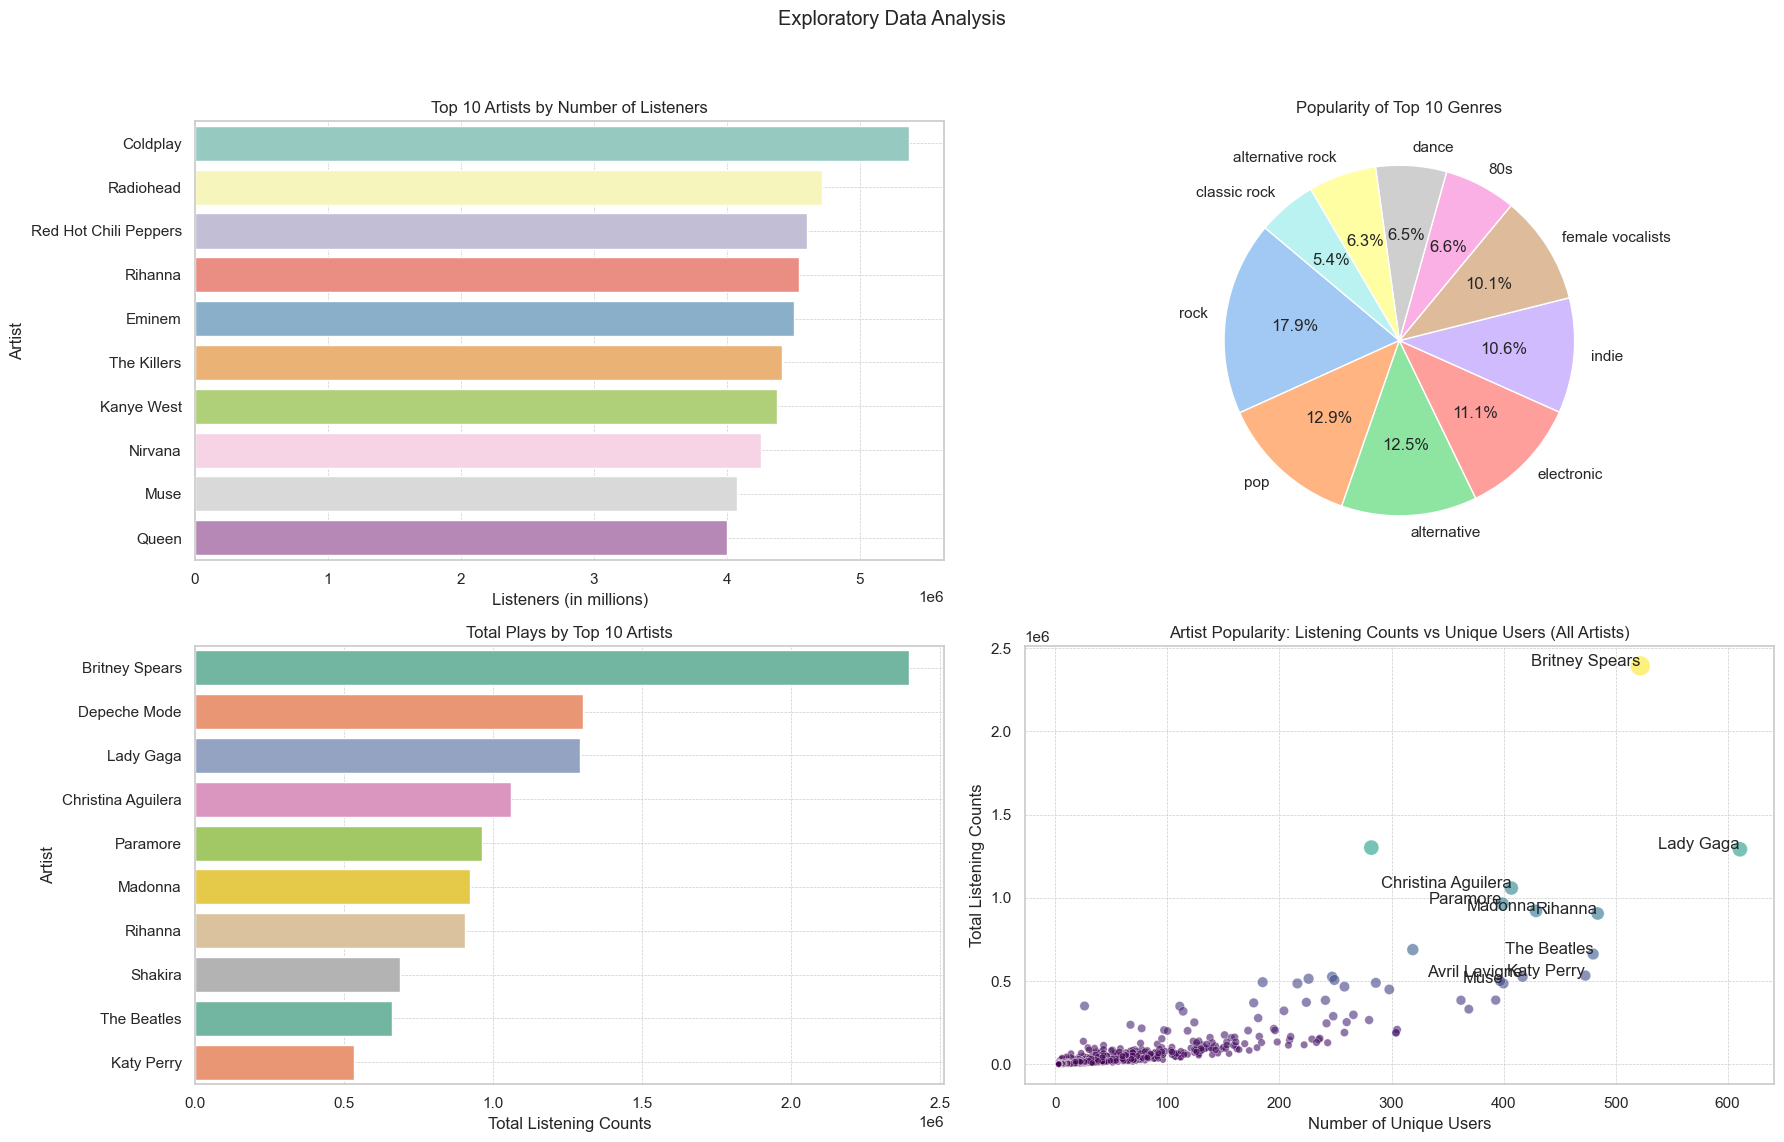

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# Subplot area
fig, axes = plt.subplots(2, 2, figsize = (18, 12))
fig.suptitle('Exploratory Data Analysis')

# Popularity of Artists
top_artists = artists.sort_values(by = 'listeners', ascending = False).head(10)
sns.barplot(x = 'listeners', y = 'name', data = top_artists,  ax = axes[0, 0], palette = 'Set3')
axes[0, 0].set_title('Top 10 Artists by Number of Listeners')
axes[0, 0].set_xlabel('Listeners (in millions)')
axes[0, 0].set_ylabel('Artist')
axes[0, 0].grid(True, which="both", ls="--", linewidth=0.5)

# Popularity of Genres
genre_counts = user_tag_artist.groupby('tagID').size().sort_values(ascending=False).head(10)
top_genres = pd.merge(genre_counts.reset_index(), tags, how='left', on='tagID')
axes[0, 1].pie(top_genres[0], labels=top_genres['tagValue'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
axes[0, 1].set_title('Popularity of Top 10 Genres')

# Total Plays by Artist (Listening Counts)
total_plays_by_artist = users.groupby('artistID')['weight'].sum().sort_values(ascending=False).head(10)
top_artists_by_plays = pd.merge(total_plays_by_artist.reset_index(), artists, on='artistID')
sns.barplot(x='weight', y='name', data=top_artists_by_plays,  ax = axes[1, 0], palette='Set2')
axes[1, 0].set_title('Total Plays by Top 10 Artists')
axes[1, 0].set_xlabel('Total Listening Counts')
axes[1, 0].set_ylabel('Artist')
axes[1, 0].grid(True, which="both", ls="--", linewidth=0.5)

# Identifying the top 10 artists by popularity (considering both unique users and total listening counts)
artist_popularity_all = users.groupby('artistID').agg({'userID': pd.Series.nunique, 'weight': 'sum'})
artist_popularity_all = artist_popularity_all.merge(artists[['artistID', 'name']], on='artistID')
top_artists_by_popularity = artist_popularity_all.sort_values(by=['userID', 'weight'], ascending=False).head(10)
sns.scatterplot(x='userID', y='weight', data=artist_popularity_all, size='weight', hue='weight', legend=False, alpha=0.6, sizes=(20, 200),  ax = axes[1, 1], palette='viridis')
for i in range(top_artists_by_popularity.shape[0]):
    plt.text(top_artists_by_popularity.iloc[i]['userID'], top_artists_by_popularity.iloc[i]['weight'], top_artists_by_popularity.iloc[i]['name'], horizontalalignment='right')
axes[1, 1].set_title('Artist Popularity: Listening Counts vs Unique Users (All Artists)')
axes[1, 1].set_xlabel('Number of Unique Users')
axes[1, 1].set_ylabel('Total Listening Counts')
axes[1, 1].grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout(rect = [0, 0.03, 1, 0.95])
plt.show()
